Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
decode_L1.m\
Description: Script for decoding analysis on layer 1 of probabilistic RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.optimize import curve_fit
from scipy.io import loadmat

In [3]:
# MODIFY HERE
# what conditions were the RNNs trained on?
RNN_params = {}
RNN_params['prob_split'] = '70_30'
RNN_params['afc'] = 2
RNN_params['coh'] = 'hi'
RNN_params['feedback'] = False
RNN_params['thresh'] = [.3,.7]

# Decoding params
D_params = {}
D_params['time_avg'] = False
D_params['t_win'] = [200,-1]
D_params['n_cvs'] = 5
D_params['num_cgs'] = 30
D_params['label'] = 'stim' # 'stim' or 'choice'
D_params['units'] = 'all' # 'all' or 'exc' or 'inh'
D_params['pred'] = 'expected' # 'expected' or 'unexpected', trials had stim 0 or 1 dominant

# Timing of task
task_info = {}
task_info['trials'] = 1000
task_info['trial_dur'] = 250  # trial duration (timesteps)
task_info['stim_on'] = 80
task_info['stim_dur'] = 50
# decode opts
time_avg = False # do we want to look at average over time window?
if time_avg:
    t_win = [ 200,-1 ]
n_cvs = 5
window = 50
# store the accuracy
acc = np.full( ( n_cvs ), np.nan )

# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )


In [4]:
# Data Directory
# Load data
if sys.platform.startswith('linux'):
    data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"
else:
    data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"

# Chose the model
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[0]) 
model = loadmat(model_path) # model.keys()

# Change this if we want a different number of trials and different default stim (0 is the one RNN was trained on)
if D_params['pred'] == 'expected':
    data_file = f"{data_dir}/Trials{task_info['trials']}_model{model_path[-7:-4]}_0expected.npz"
elif D_params['pred'] == 'unexpected':
    data_file = f"{data_dir}/Trials{task_info['trials']}_model{model_path[-7:-4]}_1unexpected.npz"
data = np.load(data_file)



______________________________________________________________________

## Next: Compare decode expected vs. unexpected
Hypothesis: We can decode expected stimulus better than unexpected because the RNN has acquired the expectation. 

### Decode expected stim input

In [5]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
data_d = data['fr1']
labs = data['labs'].squeeze()

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out

# filter by trial type
# TODO make sure expected only has expected and unexpected only has unexpected

In [6]:
def sliding_window(elements, window_size):
  if len(elements) <= window_size:
    return elements

  windows = []
  for i in range(len(elements) - window_size + 1):
    windows.append(elements[i:i + window_size])

  return windows

In [ ]:
tmp = sliding_window([1,2,3,4,5,6,7,8,9],2)


In [14]:
# Do decoding
if time_avg:
    data_d = np.mean( data_d[ :,t_win[0]:t_win[1],: ], axis = 1 ) # average over time window   
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        X = data_d[ trn_ind,: ]
        y = labs[trn_ind]

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    decoding_acc = np.zeros((len(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur'])),))

    times = sliding_window(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), window)
    counter = 0
    #for t in times: was taking too long so just try first window
    for t in times[0:15]:
      # Get data slice for the current window avg
        data_slice = np.mean( data_d[:,t, :], axis = 1 )
    
        # loop over cvs and do classification
        for i in range(n_cvs):
    
            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]
    
            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )
    
            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = labs[trn_ind]
    
            # fit the model
            grid.fit( X,y )
    
            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')
    
            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = labs[tst_ind]
    
            # predict!
            acc[ i ] = grid.score( X_test,y_test )
        counter +=1
        decoding_acc[counter] = np.mean(acc)        
        
print(f'done decoding')



done decoding


In [15]:
plots = True

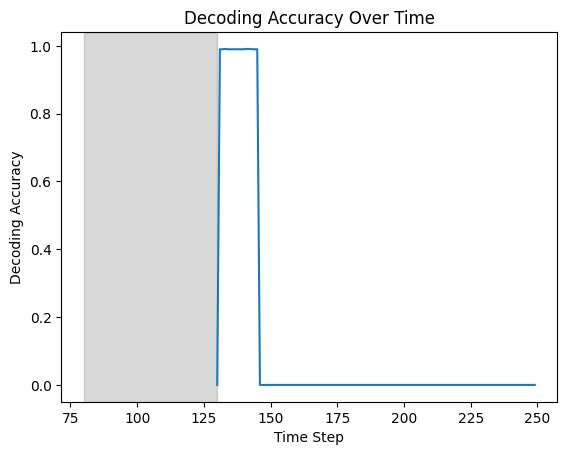

In [16]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['stim_dur']+task_info['stim_on'],task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_stim_exp.png")
    plt.show()  

In [ ]:
# fit logistic function
def logistic_func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_stim_expfit.png")
plt.show()

### Decode unexpected stim input

In [ ]:
# Decode trials: RNN stim presented

# get the data from layer 1 decode stim
# this is a [trial x time step x unit] matrix
data_d = data_unexpected['fr1']
labs = data_unexpected['labs'].squeeze()


In [ ]:
# Do decoding
if time_avg:
    data_d = np.mean( data_d[ :,t_win[0]:t_win[1],: ], axis = 1 ) # average over time window  
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        X = data_d[ trn_ind,: ]
        y = labs[trn_ind]

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = labs[trn_ind]

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = labs[tst_ind]

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



In [ ]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_stim_unx.png")
    plt.show()  

In [ ]:
# fit logistic function
popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_stim_unxfit.png")
plt.show()

______________________________________________________________________

______________________________________________________________________

### Decode expected stim choice

In [ ]:
# Decode trials: RNN stim choice

# get the data from layer 1 decode choice
# this is a [trial x time step x unit] matrix
data_d = data_expected['fr1']
labs = data_expected['outs'][:,-1]

In [ ]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_d[ trn_ind,: ]
        y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)#np.select([labs[trn_ind] >= thresh], [1], default=0) 

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = np.select([labs[tst_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



In [ ]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_choice_exp.png")
    plt.show() 

In [ ]:
# fit logistic function
popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_choice_expfit.png")
plt.show()

### Decode unexpected stim choice

In [ ]:
# Decode trials: RNN stim choice

# get the data from layer 1 decode choice
# this is a [trial x time step x unit] matrix
data_d = data_unexpected['fr1']
labs = data_unexpected['outs'][:,-1]


In [ ]:
# Do decoding
if time_avg:
       
        # Within each cross-validation fold
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        X = data_d[ trn_ind,: ]
        y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)#np.select([labs[trn_ind] >= thresh], [1], default=0) 

        # Fit the model on the binary labels
        grid.fit( X, y )

        # get the test data (X) and the test labels (y)
        X_test = data_d[tst_ind, :]
        y_test = np.select([labs[tst_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

        # Evaluate accuracy
        accuracy = np.mean( acc )
        # Print overall results
        print(f'CV: {i}, {grid.best_estimator_}')  
        
else:
    
    total_iterations = task_info['trial_dur'] * n_cvs
    decoding_acc = np.zeros((task_info['trial_dur'],))
    for t_step in range(task_info['trial_dur']):

        data_slice = data_d[:, t_step, :]

        # loop over cvs and do classification
        for i in range(n_cvs):

            # trials to hold out as test set on this cv fold
            tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

            # index into the training data on this cv fold
            trn_ind = np.setdiff1d( tri_ind, tst_ind )

            # get the training data (X) and the training labels (y)
            X = data_slice[trn_ind,:]
            y = np.select([labs[trn_ind] >= thresh[1], labs[trn_ind] <= thresh[0]], [0,1], default=0)

            # fit the model
            grid.fit( X,y )

            # progress report
            #print(f'CV: {i}, {grid.best_estimator_}')

            # get the test data (X) and the test labels (y)
            X_test = data_slice[tst_ind, :]
            y_test = np.select([labs[tst_ind] >= thresh[1], labs[tst_ind] <= thresh[0]], [0,1], default=0)

            # predict!
            acc[ i ] = grid.score( X_test,y_test )
            update_progress((t_step * n_cvs) + i + 1, total_iterations)
        decoding_acc[t_step] = np.mean(acc)        
    plots = True # show decoding acc over time
    print('')  # Print a newline after the progress bar    
print(f'done decoding')



In [ ]:
if plots:
    # Plot decoding accuracy over time
    plt.figure()
    plt.plot(range(task_info['trial_dur']), decoding_acc)
    plt.xlabel('Time Step')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy Over Time')
    plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
    plt.savefig(f"{data_dir}/decode_choice_unx.png")
    plt.show() 

In [ ]:
# fit logistic function
popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), decoding_acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), decoding_acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
plt.savefig(f"{data_dir}/decode_choice_unxfit.png")
plt.show()